# Classifying Meteors

## Setting up

In [14]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import f1_score

PATH = "Data/Dados10/"
sz=224 #Image size

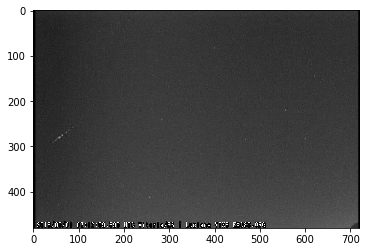

In [10]:
exemplo = os.listdir(f'{PATH}Fold0/valid/Meteoros')[0]
img = plt.imread(f'{PATH}Fold0/valid/Meteoros/{exemplo}')
plt.imshow(img);

In [7]:
def top_down_data(number,batch):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_paths(f'{PATH}Fold{number}/', bs=batch, tfms=tfms)

def normal_data(number,batch):
    tfms = tfms_from_model(arch, sz)
    return ImageClassifierData.from_paths(f'{PATH}Fold{number}/', bs=batch, tfms=tfms)

def side_data(number,batch):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_paths(f'{PATH}Fold{number}/', bs=batch, tfms=tfms)

## Pre-trained models

In [26]:
arch=resnet18
#arch=resnet34
#arch=resnet50
#arch=resnet101
cv_learn=[[]for i in range(0,10)]
data=[[]for i in range(0,10)]
for fold in range(0,10):
    data[fold] = normal_data(fold,48)
    cv_learn[fold] = ConvLearner.pretrained(arch, data[fold], precompute=True)
    #lrf=cv_learn[fold].lr_find(start_lr=1e-3, end_lr=1) #buscando learning rates
    #cv_learn[fold].sched.plot()

In [27]:
lr=3e-2
for fold in range(0,10):
    print(f'Batch {fold}')
    cv_learn[fold].fit(lr,2,cycle_len=1,cycle_mult=2) 
    lr=1e-3
    cv_learn[fold].unfreeze()
    cv_learn[fold].fit([0,lr,lr],3) 

Batch 0


epoch      trn_loss   val_loss   accuracy                  
    0      0.476944   0.243995   0.903614  
    1      0.390391   0.247975   0.915663                 
    2      0.322954   0.281249   0.915663                 



epoch      trn_loss   val_loss   accuracy                  
    0      0.335115   0.237126   0.921687  
    1      0.284775   0.239388   0.927711                  
    2      0.274859   0.24093    0.915663                  

Batch 1


epoch      trn_loss   val_loss   accuracy                 
    0      0.59409    0.48239    0.771084  
    1      0.494796   0.333551   0.849398                  
    2      0.438088   0.326931   0.855422                 



epoch      trn_loss   val_loss   accuracy                  
    0      0.392704   0.29933    0.861446  
    1      0.371791   0.263114   0.879518                  
    2      0.341166   0.250452   0.89759                   

Batch 2


epoch      trn_loss   val_loss   accuracy                  
    0      0.695408   0.41928    0.844311  
    1      0.546753   0.24992    0.916168                 
    2      0.480287   0.246142   0.91018                   



epoch      trn_loss   val_loss   accuracy                  
    0      0.364157   0.210876   0.922156  
    1      0.339738   0.187487   0.94012                   
 81%|████████▏ | 26/32 [00:03<00:00,  7.24it/s, loss=0.343]

KeyboardInterrupt: 

In [25]:
#F1 scores
for fold in range(0,10):
    log_preds = cv_learn[fold].predict()
    preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
    probs = np.exp(log_preds[:,1])   # pr(dog)
    print(f1_score(data[fold].val_y, preds))
    #plot_confusion_matrix(cm, data[0].classes)

0.9032258064516129
0.9076923076923077
0.9374999999999999
0.9016393442622951
0.9291338582677167
0.9302325581395349
0.921875
0.923076923076923
0.8730158730158729
0.8907563025210083


# Training from scratch

In [29]:
from fastai.models.resnet import yuri_resnet18

arch=resnet18
m= [[]for i in range(0,10)]
bm=[[]for i in range(0,10)]
cv_learn=[[]for i in range(0,10)]
data=[[]for i in range(0,10)]
for fold in range(0,10):
    m[fold]= yuri_resnet18()
    bm[fold] = BasicModel(m[fold].cuda(), name=f'resnet18{fold}')
    data[fold] = normal_data(fold,48)
    cv_learn[fold] = ConvLearner(data[fold], bm[fold])
    #lrf=cv_learn[fold].lr_find(1e-5,1e-3) #buscando learning rates
    #cv_learn[fold].sched.plot()




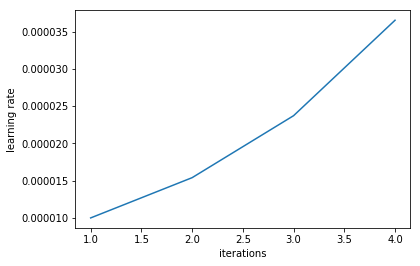

In [5]:
cv_learn[1].sched.plot_lr()

In [30]:
lr=2e-4
for fold in range(0,10):
    cv_learn[fold].fit(lr,3,cycle_len=1,cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                     
    0      -0.052387  0.083216   0.638554  
    1      -0.220163  -0.602208  0.76506                     
epoch      trn_loss   val_loss   accuracy                    
    0      -0.094477  0.065484   0.520958  
    1      -0.288432  -0.546952  0.766467                   
    2      -0.524635  -0.690817  0.778443                   
    3      -0.830082  -1.126997  0.718563                   
    4      -1.390553  -1.225014  0.550898                   
    5      -2.044735  -2.397544  0.754491                  
    6      -2.556384  -3.753955  0.850299                  


epoch      trn_loss   val_loss   accuracy                   
    0      -0.193     -0.230558  0.618182  
    1      -0.399337  -0.50685   0.751515                   
    2      -0.598425  -0.882533  0.775758                   
    3      -0.914259  5.67553    0.509091                   
    4      -1.452968  -1.4454    0.563636                  
    5      -2.092345  -1.800448  0.630303                  
    6      -2.581032  -3.314907  0.806061                  


epoch      trn_loss   val_loss   accuracy                      
    0      -0.012775  0.031438   0.551515  
    1      -0.183781  -0.358248  0.563636                    
    2      -0.377912  -0.756954  0.806061                   
    3      -0.643748  -0.502434  0.557576                   
    4      -1.171556  -2.607908  0.612121                   
    5      -1.814904  -2.870088  0.854545                  
    6      -2.272282  -3.271766  0.866667                  


epoch      trn_loss   val_loss   accuracy                     
    0      -0.070151  -0.065978  0.638554  
    1      -0.239174  -0.297672  0.722892                   
    2      -0.41831   -0.585532  0.759036                   
    3      -0.663856  -0.690444  0.554217                   
    4      -1.137326  -1.559182  0.753012                   
    5      -1.683067  -1.887719  0.789157                  
    6      -2.108887  -2.298255  0.807229                  


epoch      trn_loss   val_loss   accuracy                     
    0      -0.080894  -0.001218  0.638554  
    1      -0.24477   -0.360696  0.614458                   
    2      -0.428614  -0.631025  0.789157                   
    3      -0.698317  1.45124    0.39759                    
    4      -1.180273  -1.599219  0.674699                   
    5      -1.737034  -3.011771  0.849398                  
    6      -2.22939   -3.029647  0.873494                  


epoch      trn_loss   val_loss   accuracy                    
    0      -0.11503   -0.173699  0.650602  
    1      -0.311676  -0.752599  0.771084                   
    2      -0.554973  -0.955593  0.771084                   
    3      -0.877401  -1.472414  0.789157                   
    4      -1.390818  -2.322112  0.777108                  
    5      -1.919453  -3.405078  0.813253                  
    6      -2.382727  -3.594517  0.837349                  


epoch      trn_loss   val_loss   accuracy                    
    0      -0.157889  -0.136208  0.620482  
    1      -0.343847  -0.23046   0.506024                   
    2      -0.551592  -0.808452  0.795181                   
    3      -0.847662  -0.323984  0.493976                   
    4      -1.465151  -2.053968  0.759036                  
    5      -2.196699  -2.445184  0.596386                  
    6      -2.759122  -4.036422  0.86747                   


epoch      trn_loss   val_loss   accuracy                    
    0      -0.127167  -0.101721  0.626506  
    1      -0.320802  -0.40219   0.548193                   
    2      -0.530673  -0.831303  0.759036                   
    3      -0.805625  -1.191266  0.60241                    
    4      -1.317027  -0.089634  0.415663                   
    5      -1.857456  -2.323626  0.783133                  
    6      -2.285239  -2.893711  0.819277                  


In [31]:
#F1 scores
for fold in range(0,10):
    log_preds = cv_learn[fold].predict()
    preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
    probs = np.exp(log_preds[:,1])   # pr(dog)
    print(f1_score(data[fold].val_y, preds))
    #plot_confusion_matrix(cm, data[0].classes)

0.7731092436974791
0.7079646017699115
0.7967479674796748
0.6981132075471698
0.819672131147541
0.7037037037037038
0.8264462809917356
0.7804878048780488
0.8253968253968254
0.7368421052631579


# Fashion MNIST

In [13]:
f_model=resnet18
FPATH = 'Data/Fashion-MNIST/'
label_csv = f'{FPATH}train-labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
data=ImageClassifierData.from_csv(FPATH, '', label_csv, tfms=tfms,
                     val_idxs=val_idxs, test_name='test-images')

In [16]:
m= yuri_resnet18()
bm = BasicModel(m.cuda(), name='resnet18')
learn = ConvLearner(data, bm)
learn = ConvLearner.pretrained(f_model, data)
#lrf=learn.lr_find()
#learn.sched.plot()

In [17]:
learn.fit(1e-2,1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.599866   0.53494    0.798567  


[array([0.53494]), 0.7985665472222027]

In [18]:
learn.fit(1e-2,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.562551   0.481648   0.824652  
    1      0.537684   0.469246   0.829069                    
    2      0.528154   0.458488   0.834236                    
    3      0.525021   0.459914   0.829236                    
    4      0.501841   0.439301   0.840903                    
    5      0.484551   0.430004   0.84132                     
    6      0.50696    0.428434   0.845154                    


[array([0.42843]), 0.8451537628185353]

In [19]:
learn.save('fashion-MNIST_scratch')
#learn.save('fashion-MNIST_int')

 83%|████████▎ | 625/750 [02:56<00:35,  3.53it/s, loss=1.87] 

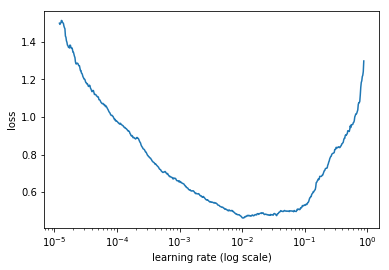

In [14]:
learn.unfreeze()
lrf=learn.lr_find()
learn.sched.plot()

In [42]:
learn.unfreeze()
lr= 3e-3
learn.fit(lr,2,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.358276   0.307769   0.86747   
    1      0.383131   0.268412   0.885542                  
    2      0.387731   0.22821    0.885542                  


[array([0.22821]), 0.8855421772922378]

epoch      trn_loss   val_loss   accuracy                 
    0      2.099348   6.917034   0.819277  


epoch      trn_loss   val_loss   accuracy                 
    0      2.156054   22.379449  0.704819  


epoch      trn_loss   val_loss   accuracy                 
    0      2.471767   59.050874  0.60479   


epoch      trn_loss   val_loss   accuracy                 
    0      2.200702   5.535495   0.878788  


epoch      trn_loss   val_loss   accuracy                 
    0      2.155296   8.833173   0.860606  


epoch      trn_loss   val_loss   accuracy                 
    0      2.130235   10.364231  0.849398  


epoch      trn_loss   val_loss   accuracy                 
    0      2.282516   21.170091  0.536145  


epoch      trn_loss   val_loss   accuracy                 
    0      2.182653   9.05191    0.873494  


epoch      trn_loss   val_loss   accuracy                 
    0      2.064342   7.409821   0.807229  


epoch      trn_loss   val_loss   accuracy                 
    0      1.938504   3.433987   0.873494  


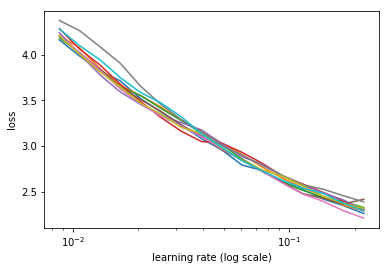

In [21]:
arch=resnet18
cv_learn=[[]for i in range(0,10)]
data=[[]for i in range(0,10)]
for fold in range(0,10):
    data[fold] = normal_data(fold,48)
    learn.set_data(data[fold])
    cv_learn[fold] = learn
    cv_learn[fold].freeze()
    lrf=cv_learn[fold].lr_find(start_lr=1e-3, end_lr=1) #buscando learning rates
    cv_learn[fold].sched.plot()

In [23]:
lr=0.1
for fold in range(0,10):
    cv_learn[fold].fit(lr,1,cycle_len=3) 

epoch      trn_loss   val_loss   accuracy                  
    0      0.171715   0.225714   0.945783  
    1      0.208811   0.26875    0.939759                  
    2      0.195844   0.211955   0.939759                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.192327   0.256721   0.909639  
    1      0.225463   0.240273   0.933735                  
    2      0.183222   0.263786   0.909639                  


epoch      trn_loss   val_loss   accuracy                   
    0      0.159321   0.217046   0.939759  
    1      0.178455   0.224522   0.915663                  
    2      0.218255   0.195625   0.939759                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.218972   0.234196   0.921687  
    1      0.202018   0.234391   0.933735                  
    2      0.178601   0.212195   0.939759                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.167002   0.255848   0.89759   
    1      0.194549   0.2016     0.927711                  
    2      0.177542   0.206531   0.939759                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.148131   0.231789   0.939759  
    1      0.166674   0.226874   0.933735                  
    2      0.157352   0.238695   0.927711                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.130501   0.226455   0.939759  
    1      0.13486    0.225385   0.927711                  
    2      0.14722    0.214146   0.945783                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.194797   0.222446   0.933735  
    1      0.183602   0.233295   0.927711                  
    2      0.203962   0.25172    0.945783                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.146271   0.201139   0.951807  
    1      0.169137   0.184504   0.945783                  
    2      0.152553   0.208477   0.939759                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.171064   0.323462   0.927711  
    1      0.203037   0.248789   0.933735                  
    2      0.168827   0.246718   0.939759                  


In [24]:
lr=1e-3
for fold in range(0,10):
    cv_learn[fold].precompute=False
    cv_learn[fold].unfreeze()
    cv_learn[fold].fit([0,lr,lr],3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.573134   0.476167   0.903614  
    1      0.478703   0.435932   0.873494                  
    2      0.402618   0.241921   0.921687                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.209295   0.201123   0.921687  
    1      0.196116   0.181054   0.951807                  
    2      0.205054   0.182509   0.963855                  


epoch      trn_loss   val_loss   accuracy                  
    0      0.144974   0.185032   0.951807  
    1      0.143699   0.194169   0.945783                  
    2      0.120179   0.228788   0.957831                  


epoch      trn_loss   val_loss   accuracy                   
    0      0.112697   0.176121   0.957831  
    1      0.112998   0.185246   0.957831                  
    2      0.128083   0.190927   0.963855                  


epoch      trn_loss   val_loss   accuracy                   
    0      0.081887   0.148743   0.975904  
    1      0.157482   0.168089   0.963855                   
    2      0.172039   0.194834   0.957831                  


epoch      trn_loss   val_loss   accuracy                   
    0      0.258433   0.215403   0.951807  
    1      0.2355     0.201858   0.921687                  
    2      0.180095   0.165012   0.96988                   


epoch      trn_loss   val_loss   accuracy                   
    0      0.10775    0.179211   0.957831  
    1      0.086053   0.171797   0.951807                   
    2      0.115617   0.178081   0.963855                   


epoch      trn_loss   val_loss   accuracy                   
    0      0.103219   0.203853   0.939759  
    1      0.156201   0.267463   0.945783                  
    2      0.138286   0.232427   0.945783                  


epoch      trn_loss   val_loss   accuracy                   
    0      0.126876   0.228549   0.957831  
    1      0.153421   0.203541   0.957831                  
    2      0.125511   0.208977   0.963855                  


epoch      trn_loss   val_loss   accuracy                   
    0      0.059905   0.215169   0.957831  
    1      0.076879   0.203737   0.963855                   
    2      0.069727   0.248588   0.951807                   


In [28]:
#data=[[]for i in range(0,10)]
for fold in range(5,10):
    #data[fold] = normal_data(fold,48)
    log_preds = cv_learn[fold].predict()
    preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
    probs = np.exp(log_preds[:,1])   # pr(dog)
    print(f1_score(data[fold].val_y, preds))

0.9374999999999999
0.9374999999999999
0.9374999999999999
0.9374999999999999
0.9374999999999999
